<a href="https://colab.research.google.com/github/KalikaKay/Thinkful-Notebooks/blob/main/Supervised_Learning_Model_Selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#####import files


In [ ]:
#Access to Google files
import gspread 
from google.colab import auth
from oauth2client.client import GoogleCredentials

#Data Exploration: Dataframe and visualizations
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from matplotlib.collections import PatchCollection
import math
from scipy import stats
import math
sns.set()

#Data Cleaning - Test Split
from sklearn.model_selection import train_test_split, cross_val_score


#Feature Engineering
from sklearn.utils import resample
from sklearn.feature_selection import SelectKBest, chi2, f_classif, GenericUnivariateSelect
from sklearn.decomposition import PCA

#Modeling
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

#Evaluation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

#suppress warnings
import warnings
warnings.filterwarnings('ignore')

#my favorite color
mycolor = '#F9EDF5'

##### functions


In [ ]:
def printDiag(dfa, dfb, col):

  #T=Test Variable and histograms
  #Description of the two distributions
  print("First Set:", stats.describe(dfa[col]))
  print("Second Set:", stats.describe(dfb[col]))

  #What about the p value?
  print(stats.ttest_ind(dfa[col], dfb[col]))
  print("Assuming the distribution is normal: ", get_95_ci(dfa[col], dfb[col]))

  plt.hist(dfa[col], alpha = .6, color="red")
  plt.hist(dfb[col], alpha = .2, color="white")
  #plt.xlabel=''
  plt.show()

In [ ]:
def plot_cm(cm, classes,normalize, title='Confusion matrix'):
  #Some Stylization.
  plt.style.use(['dark_background'])
  
  #Confusion Matrix 
  N = len(cm[0])
  M = len(cm[1])
  #Labels
  ylabels = [classes[0], classes[1]]
  xlabels = [classes[0], classes[1]]

  #Assign X and y.
  x, y = np.meshgrid(np.arange(M), np.arange(N))
  
  s = cm
  c = cm

  fig, ax = plt.subplots(figsize=(14, 11))

  #Circles
  R = s/s.max()/2
  circles = [plt.Circle((j,i), radius=r) for r, j, i in zip(R.flat, x.flat, y.flat)]
  col = PatchCollection(circles, array=c.flatten(), cmap=plt.cm.coolwarm)
  ax.add_collection(col)
  ax.set(xticks=np.arange(M), yticks=np.arange(N),
        xticklabels=xlabels, yticklabels=ylabels)
  ax.set_xticks(np.arange(M+1)-0.5, minor=True)
  ax.set_yticks(np.arange(N+1)-0.5, minor=True)
  ax.grid(b=False, which='minor')
  
  #Add the Text
  thresh = cm.max() / 4.
  fmt = 'd'
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
   plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center", verticalalignment="center",
            color="white")
   
  #Titles and labels. 
  plt.title = title
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  fig.colorbar(col)
  plt.show()

In [ ]:
def dummyCompetition(score):
  #Dummy Classifier, set to most_frequent for my unbalanced dataset.
  dc = DummyClassifier(strategy='most_frequent')

  #Fit and score. The goal is to beat this thing.
  dc.fit(X_train,y_train)
  dummy = dc.score(X_test, y_test)
  if (score < dummy):
    return "You lost to the dummy"
  else:
    return "You Won!"

In [ ]:
#A summary of missing variables represented as a percentage of the total missing content. 
def missingness_summary(df, print_log=False, sort='ascending'):
  s = df.isnull().sum()*100/df.isnull().count()
    
  if sort.lower() == 'ascending':
    s = s.sort_values(ascending=True)
  elif sort.lower() == 'descending':
    s = s.sort_values(ascending=False)  
  if print_log: 
    print(s)
  
  return pd.Series(s)

In [ ]:
#A map designed for a correlation matrix.  
def the_best_map(corr):
  mask = np.zeros_like(corr)
  mask[np.triu_indices_from(mask)] = False
  with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(15, 15))
    ax = sns.heatmap(data=corr, annot=True, square=True, fmt='.1g', center=0.7, mask=mask, vmin=0, vmax=1)
  plt.show()

In [ ]:
def getBest(model, cv_results, best_index):
  disinterested = ['params',	'split0_test_score',	'split1_test_score',	'split2_test_score',	'split3_test_score',	'split4_test_score']
  
  best = pd.DataFrame(cv_results).drop(columns=disinterested)
  best_score = best.iloc[best_index]
  best.dropna(inplace=True)
  best = best[(best['mean_fit_time'] == best.mean_fit_time.min()) | (best['mean_score_time'] == best.mean_score_time.min())]
  if best_index not in best:
    best = best.append(best_score)
  best['model'] = model
  return best


In [ ]:
def get_95_ci(array_1, array_2):
    sample_1_n = array_1.shape[0]
    sample_2_n = array_2.shape[0]
    sample_1_mean = array_1.mean()
    sample_2_mean = array_2.mean()
    sample_1_var = array_1.var()
    sample_2_var = array_2.var()
    mean_difference = sample_2_mean - sample_1_mean
    std_err_difference = math.sqrt((sample_1_var/sample_1_n)+(sample_2_var/sample_2_n))
    margin_of_error = 1.96 * std_err_difference
    ci_lower = mean_difference - margin_of_error
    ci_upper = mean_difference + margin_of_error
    return("The difference in means at the 95% confidence interval (two-tail) is between "+str(ci_lower)+" and "+str(ci_upper)+".")

## Modeling for Prediction
*A Thinkful Capstone Two project*

>*by Kalika Kay Curry*

This is an analysis six of sklearns's predictive classification models. 

* knn
* deicison tree 
* random forest
* svc
* linear classifier
* gradient boost

Using the [telecom churn](https://www.kaggle.com/zagarsuren/telecom-churn-dataset-ibm-watson-analytics?select=WA_Fn-UseC_-Telco-Customer-Churn.xlsx) dataset available on Kaggle, this notebook uses principle component analysis and sklearn's skbest modules retrieve the best features to use in each of the prediction models. 

Results from each predictive model are compared against a dummy classifier as a fun performance metric for the best parameters.

Last, but not least, there's a brief time comparison between each of the models using, using their minimal time results. 

# Exploratory Data Analysis

The first part of the project requires an exploration of the data, data cleaning, and feature engineering to create a clean dataset that can be interpreted by the classification models. 

## Data Exploration

In [ ]:
#Connect to the data set. 
auth.authenticate_user()
gc = gspread.authorize(GoogleCredentials.get_application_default())


wksPath = "https://docs.google.com/spreadsheets/d/14FWICDXhtn-KB6Frf3UHH3OZxa_xZ1j-qBdphM7EGvY"
wks = gc.open_by_url(wksPath).sheet1

#my main dataframe of data that I'm working with. 
df = pd.DataFrame.from_records(wks.get_all_records())

#Look at the data.
df.describe(include='all')

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
count,7043,7043,7043.000000,7043,7043,7043.000000,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043.000000,7043,7043
unique,7043,2,NaN,2,2,NaN,2,3,3,3,3,3,3,3,3,3,2,4,NaN,6531,2
top,2439-QKJUL,Male,NaN,No,No,NaN,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,NaN,,No
freq,1,3555,NaN,3641,4933,NaN,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,NaN,11,5174
mean,NaN,NaN,0.162147,NaN,NaN,32.371149,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,NaN,NaN
std,NaN,NaN,0.368612,NaN,NaN,24.559481,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,NaN,NaN
25%,NaN,NaN,0.000000,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,NaN,NaN
50%,NaN,NaN,0.000000,NaN,NaN,29.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,NaN,NaN
75%,NaN,NaN,0.000000,NaN,NaN,55.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,NaN,NaN


In [ ]:
#A dataframe containing data for reports - of missing values, datatypes and unique values for all columns.
summary = missingness_summary(df)
report = pd.concat([summary.rename('nullCount'), df.dtypes.reindex(summary.index).rename('dType')], join='inner', axis=1)
report = pd.concat([report, df.nunique().reindex(summary.index).rename('nUnique')], join='inner', axis=1)

In [ ]:
#Look at unique values for categorical data. 
threshold = 5
cats = report[report['nUnique'] < threshold].index
print("*********Value Count Report********")
print("Unique values less than {}".format(threshold))
print('*****************************************\n')
for cat in cats:
  print(df[cat].value_counts())
  print('----------------------')

*********Value Count Report********
Unique values less than 5
*****************************************

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64
----------------------
Yes    4171
No     2872
Name: PaperlessBilling, dtype: int64
----------------------
Month-to-month    3875
Two year          1695
One year          1473
Name: Contract, dtype: int64
----------------------
No                     2785
Yes                    2732
No internet service    1526
Name: StreamingMovies, dtype: int64
----------------------
No                     2810
Yes                    2707
No internet service    1526
Name: StreamingTV, dtype: int64
----------------------
No                     3473
Yes                    2044
No internet service    1526
Name: TechSupport, dtype: int64
----------------------
No                     3095
Yes                    2422
No internet service 

## Data Cleaning

In [ ]:
#columns to drop. 
drop_cols = ['customerID']

#the cleaned dataframe. 
churn = df.drop(columns = drop_cols)
churn.describe(include='all')

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
count,7043,7043.000000,7043,7043,7043.000000,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043.000000,7043,7043
unique,2,NaN,2,2,NaN,2,3,3,3,3,3,3,3,3,3,2,4,NaN,6531,2
top,Male,NaN,No,No,NaN,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,NaN,,No
freq,3555,NaN,3641,4933,NaN,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,NaN,11,5174
mean,NaN,0.162147,NaN,NaN,32.371149,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,NaN,NaN
std,NaN,0.368612,NaN,NaN,24.559481,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,NaN,NaN
min,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,NaN,NaN
25%,NaN,0.000000,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,NaN,NaN
50%,NaN,0.000000,NaN,NaN,29.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,NaN,NaN
75%,NaN,0.000000,NaN,NaN,55.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,NaN,NaN


In [ ]:
report[report.index == 'TotalCharges']

,nullCount,dType,nUnique
TotalCharges,0.0,object,6531


In [ ]:
churn[churn["TotalCharges"]==' ']

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5218,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
6670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


There's non-numeric data in the total charges field.

In [ ]:
#Assign to a seperate variable.  
holdout = churn[churn['TotalCharges'] == ' ']

#convert to numeric
churn['TotalCharges'] = pd.to_numeric(churn['TotalCharges'], errors='coerce')
#drop the nulls.
churn = churn.dropna()


Churn, is exhibiting an interesting behavior pattern. 

It will not allow a direct conditional comparison - using the string. Set the condition on the key value.

In [ ]:
#set the value that I will be assigning to zero to the first value in the key array. 
key = df['Churn'].value_counts().keys()[0]

In [ ]:
#assign churn the key values instead of the string values. 
churn['Churn'] = np.where(churn['Churn'] == key, 0, 1)
churn['Churn'].describe()

count    7032.000000
mean        0.265785
std         0.441782
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: Churn, dtype: float64

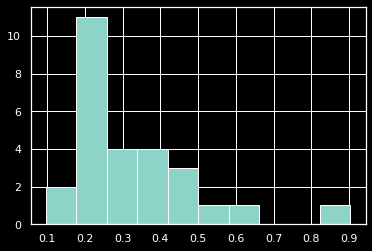

In [ ]:
#Size of the test set and target variable to split the data.
target = 'Churn'
SIZE = 0.2

#Assign the target and feature variables. 
y = churn[target]
X = churn.drop(columns=[target])

#Convert categorical to numerical.
X = pd.get_dummies(X, drop_first=True)

#check for balance.
balance = X.mean()
balance = balance[balance.values < 1]

plt.style.use(['dark_background'])
balance.hist()
plt.show()

In [ ]:
balance.sort_values()

MultipleLines_No phone service           0.096701
SeniorCitizen                            0.162400
Contract_One year                        0.209329
StreamingMovies_No internet service      0.216155
StreamingTV_No internet service          0.216155
TechSupport_No internet service          0.216155
OnlineBackup_No internet service         0.216155
OnlineSecurity_No internet service       0.216155
DeviceProtection_No internet service     0.216155
InternetService_No                       0.216155
PaymentMethod_Credit card (automatic)    0.216297
PaymentMethod_Mailed check               0.228100
Contract_Two year                        0.239619
OnlineSecurity_Yes                       0.286547
TechSupport_Yes                          0.290102
Dependents_Yes                           0.298493
PaymentMethod_Electronic check           0.336320
DeviceProtection_Yes                     0.343857
OnlineBackup_Yes                         0.344852
StreamingTV_Yes                          0.384386


There aren't enough senior citizens in this dataset. 

In [ ]:
X['SeniorCitizen'].value_counts()

0    5890
1    1142
Name: SeniorCitizen, dtype: int64

In [ ]:
#Split the data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=SIZE)
print('There are {:d} training samples and {:d} test samples'.format(X_train.shape[0], X_test.shape[0]))

There are 5625 training samples and 1407 test samples


## Feature Engineering

There aren't enough senior citizens to contribute to the feature selection. 
Oversample the data by 1000 using sklearn's [resample](https://scikit-learn.org/stable/modules/generated/sklearn.utils.resample.html). 

In [ ]:
#Assign my feature variables from my original dataset. 
fs = churn[churn['SeniorCitizen'] == 1]
fs = resample(fs, random_state=42, replace=True, n_samples=6000)

fs.SeniorCitizen.value_counts()

1    6000
Name: SeniorCitizen, dtype: int64

In [ ]:
#expand the feature selection dataset to include all other customers.
fs = pd.concat([churn, fs])
fs.SeniorCitizen.value_counts()

1    7142
0    5890
Name: SeniorCitizen, dtype: int64

With a resampled dataset conduct feature analysis.
Start with a comparison analysis on the monthly charges and the total charges.

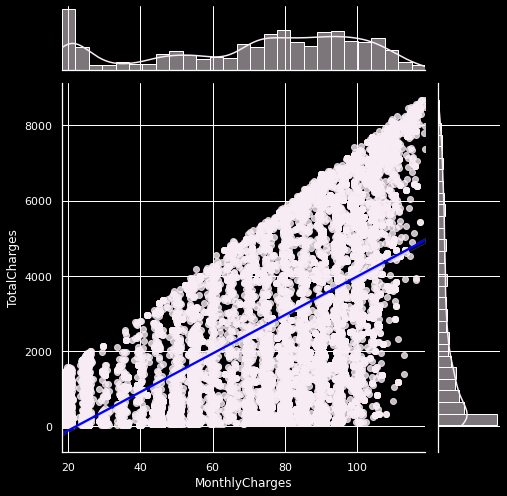

In [ ]:
plt.style.use(['dark_background'])
sns.jointplot(x=fs['MonthlyCharges'], y=fs['TotalCharges'], kind='reg', color=mycolor, line_kws={'color': 'blue'}, height=7, )
plt.show()

There appears to be a linear relationship between monthly charges and total charges. This relationship can help with identifying which features to select for churn prediction. 

Using MonthlyCharges as the target variable, predict which features are most closely related to churn. 

In [ ]:
#Construct the PCA component against monthly charges.
fsy = fs['MonthlyCharges']
#drop the target columns (senior citizen and tenure define the target (people we don't want churning))
fsX = fs.drop(columns=[target, 'SeniorCitizen', 'tenure', 'TotalCharges', 'MonthlyCharges'])

#Convert categorical to numerical.
fsX = pd.get_dummies(fsX, drop_first=True)

#Split the data.
fsX_train, fsX_test, fsy_train, fsy_test = train_test_split(fsX, fsy, test_size=SIZE)
print('There are {:d} training samples and {:d} test samples'.format(fsX_train.shape[0], fsX_test.shape[0]))
print('There are {} columns'.format(len(fsX_train.columns)))

There are 10425 training samples and 2607 test samples
There are 26 columns


Reduce the dimensionality by selecting the columns that are best for predicting monthly charges. 

In [ ]:
skb = SelectKBest(k=22)
skb.fit_transform(fsX_train, fsy_train)
skb.transform(fsX_test)
mask = skb.get_support()
#Assign the columns to a variable to perform the component analysis. 
pca_columns = fsX_train.columns[mask].values
pca_columns

array(['PhoneService_Yes', 'MultipleLines_No phone service',
       'MultipleLines_Yes', 'InternetService_Fiber optic',
       'InternetService_No', 'OnlineSecurity_No internet service',
       'OnlineSecurity_Yes', 'OnlineBackup_No internet service',
       'OnlineBackup_Yes', 'DeviceProtection_No internet service',
       'DeviceProtection_Yes', 'TechSupport_No internet service',
       'TechSupport_Yes', 'StreamingTV_No internet service',
       'StreamingTV_Yes', 'StreamingMovies_No internet service',
       'StreamingMovies_Yes', 'Contract_One year', 'Contract_Two year',
       'PaperlessBilling_Yes', 'PaymentMethod_Electronic check',
       'PaymentMethod_Mailed check'], dtype=object)

Create the principle component that best represents the monthly charges and assign the feature and target variables that will be used to predict churn. 

In [ ]:
#PCA Component
pca = X[pca_columns]
comp = PCA(n_components=2)

pca = pd.DataFrame(data = comp.fit_transform(pca), columns = ['related_charges1', 'Related_charges2'])

In [ ]:
#set X equal to my first cleaned data frame (start over)
X = pd.concat([churn, pca], axis=1, join='inner')

#set X and y. 
y = churn[target]
X = churn.drop(columns=[target])

#Convert categorical to numerical.
X = pd.get_dummies(X, drop_first=True)

#Remove pca_columns. They're now components. 
X = X.drop(columns=pca_columns)
#Set the features. 
X = X.drop(columns=['SeniorCitizen', 'tenure', 'TotalCharges']) 

In [ ]:
#split the data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=SIZE)
print('There are {:d} training samples and {:d} test samples'.format(X_train.shape[0], X_test.shape[0]))

There are 5625 training samples and 1407 test samples


#Modeling 

In [ ]:
#Some constant variables for parameter settings. 
#cross validation, constant parameter
cv = 5

#multiclass
mc = ['auto', 'ovr', 'multinomial']
#solver
sv = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
#penalty
py = ['l1', 'l2', 'elasticnet', 'none']
#criterion
cn = ['gini', 'entropy']
#max_features
mf = ['auto', 'sqrt', 'log2']
#splitter
sr = ['best', 'random']
#max_depth
md = [5, 7, 15, 29] 

#target names for classification reports. 
target_names = [df['Churn'].value_counts().keys()[0] + ' Churn', df['Churn'].value_counts().keys()[1] + ' Churn']

The base guideline for this dataset is to get a prediction model that provides a score that is greater than 68% accurate. 

Run a prediction on a dummy classifier to ensure that the features were engineered correctly. 

In [ ]:
#Dummy Classifier, set to most_frequent for my unbalanced dataset.
dc = DummyClassifier()
#Get the best parameter for the dummy model.
strategy = ['stratified', 'most_frequent', 'prior', 'uniform', 'constant']

dummies = { "strategy": strategy }
dum = GridSearchCV(dc, dummies)
dum.fit(X_train,y_train)
print(dum.best_params_, dum.best_score_)

{'strategy': 'most_frequent'} 0.7390222222222221


Compare the training score against the hold out data. It did not overfit the data. 

In [ ]:
  #Fit and score. The goal is to beat this thing.
  traindummy = dum.score(X_train, y_train)
  testdummy = dum.score(X_test, y_test)
  print("Dummy Classifier \n Training Score: {:.2f} \n Test Score: {:.2f}".format(traindummy, testdummy))

Dummy Classifier 
 Training Score: 0.74 
 Test Score: 0.71


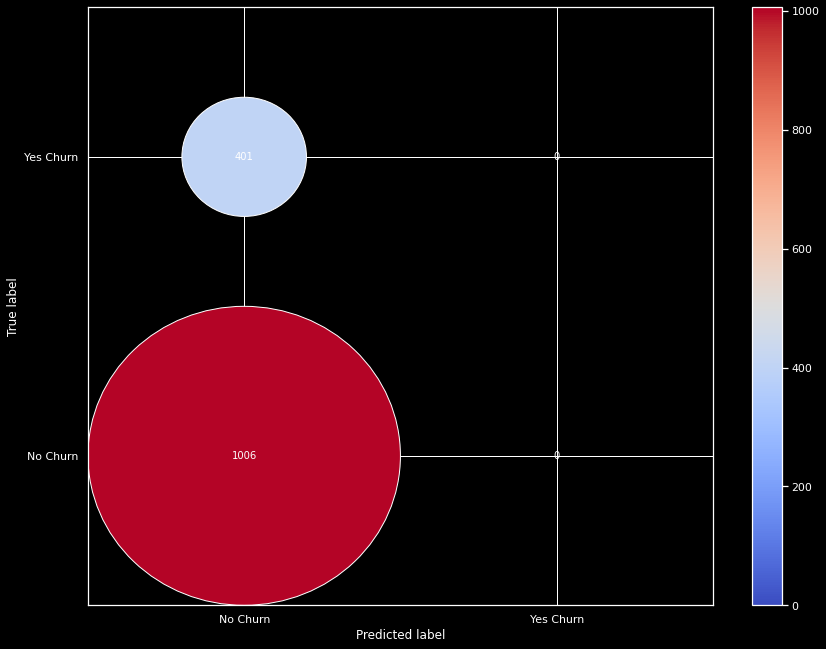

In [ ]:
#Predictions on the holdout
dumP = dum.predict(X_test)
#Confusion Matrix.
plot_cm(confusion_matrix(y_test, dumP),['No Churn','Yes Churn'],False)

In [ ]:
print(classification_report(y_test, dumP, target_names=target_names))

              precision    recall  f1-score   support

    No Churn       0.71      1.00      0.83      1006
   Yes Churn       0.00      0.00      0.00       401

    accuracy                           0.71      1407
   macro avg       0.36      0.50      0.42      1407
weighted avg       0.51      0.71      0.60      1407



The model predicts less churn when the services that it selects are combined into two components.  

This suggests that bundling some services and offering them at a lower late could reduce churn. 

In [ ]:
#Remove some columns from the frame. 
disinterested = ['params',	'split0_test_score',	'split1_test_score',	'split2_test_score',	'split3_test_score',	'split4_test_score']

#dataframe the process time and the scores.
dumResults = pd.DataFrame(dum.cv_results_)
dumResults = dumResults.drop(columns=disinterested)
dumResults.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_strategy,mean_test_score,std_test_score,rank_test_score
0,0.001354,0.000200,0.000678,0.000184,stratified,0.611022,0.006350,3
1,0.001147,0.000016,0.000407,0.000029,most_frequent,0.739022,0.000435,1
2,0.001673,0.000112,0.000797,0.000297,prior,0.739022,0.000435,1
3,0.001214,0.000070,0.000491,0.000013,uniform,0.499022,0.015474,4
4,0.000927,0.000017,0.000000,0.000000,constant,NaN,NaN,5


###Logistic Regression

In [ ]:
#Logistic Regression
lrc = LogisticRegression()
#parameters
lrcPara = { "multi_class": mc, 
           "solver": sv,
            'penalty' : py       
          }
lrcGs = GridSearchCV(lrc, lrcPara, cv=cv)

lrcGs.fit(X_train, y_train)

print("Parameters: {} \n Score: {:.2f}".format(lrcGs.best_params_, lrcGs.best_score_))
dummyCompetition(lrcGs.best_score_)

Parameters: {'multi_class': 'auto', 'penalty': 'l1', 'solver': 'saga'} 
 Score: 0.73


'You Won!'

The results dataframe stores record(s) with the minimum mean fit time score, the minimum mean score time and the best estimator. 

In [ ]:
#Set up the results table
results = getBest('lrc', lrcGs.cv_results_, lrcGs.best_index_)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_multi_class,param_penalty,param_solver,mean_test_score,std_test_score,rank_test_score,model
22,0.014473,0.001257,0.001581,0.000129,ovr,l1,liblinear,0.726222,0.002696,26,lrc
46,0.064901,0.005959,0.001370,0.000014,multinomial,l2,lbfgs,0.726222,0.002975,21,lrc
4,0.079995,0.002584,0.001505,0.000101,auto,l1,saga,0.730667,0.003813,1,lrc


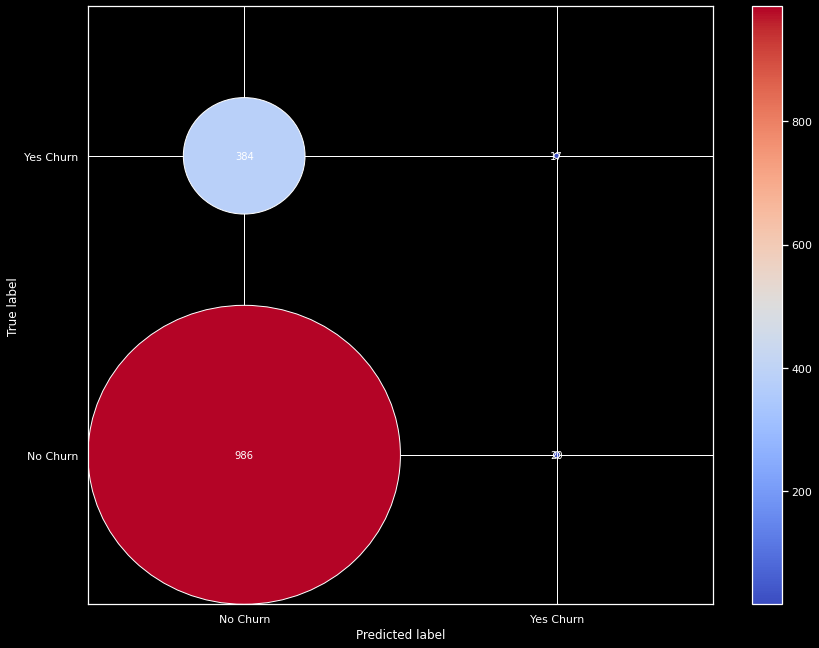

In [ ]:
#Prediction on the holdout model. 
lrcP = lrcGs.predict(X_test)
plot_cm(confusion_matrix(y_test, lrcP),['No Churn','Yes Churn'],False)

In [ ]:
#Classification report 
print(classification_report(y_test, lrcP, target_names=target_names))

              precision    recall  f1-score   support

    No Churn       0.72      0.98      0.83      1006
   Yes Churn       0.46      0.04      0.08       401

    accuracy                           0.71      1407
   macro avg       0.59      0.51      0.45      1407
weighted avg       0.65      0.71      0.62      1407



## Decision Tree

In [ ]:
#Logistic Regression
dt = DecisionTreeClassifier()
#parameters
dtPara = {'criterion': cn,
           'max_features': mf,
           'splitter':sr, 
           'max_depth': md     
          }
dtGs = GridSearchCV(dt, dtPara, cv=cv)

dtGs.fit(X_train, y_train)

print("Parameters: {} \n Score: {:.2f}".format(dtGs.best_params_, dtGs.best_score_))
dummyCompetition(dtGs.best_score_)

Parameters: {'criterion': 'entropy', 'max_depth': 5, 'max_features': 'log2', 'splitter': 'best'} 
 Score: 0.74


'You Won!'

In [ ]:
#Update the results table
results = results.append(getBest('dt', dtGs.cv_results_, dtGs.best_index_))
#look at the results
results[results['model'] == 'dt'].dropna(axis=1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,mean_test_score,std_test_score,rank_test_score,model,param_criterion,param_max_depth,param_max_features,param_splitter
25,0.002668,0.000063,0.001147,0.000028,0.738489,0.002345,6,dt,entropy,5,auto,random
27,0.002710,0.000130,0.001136,0.000031,0.738844,0.002943,4,dt,entropy,5,sqrt,random
28,0.004257,0.000460,0.001206,0.000048,0.739378,0.011417,1,dt,entropy,5,log2,best


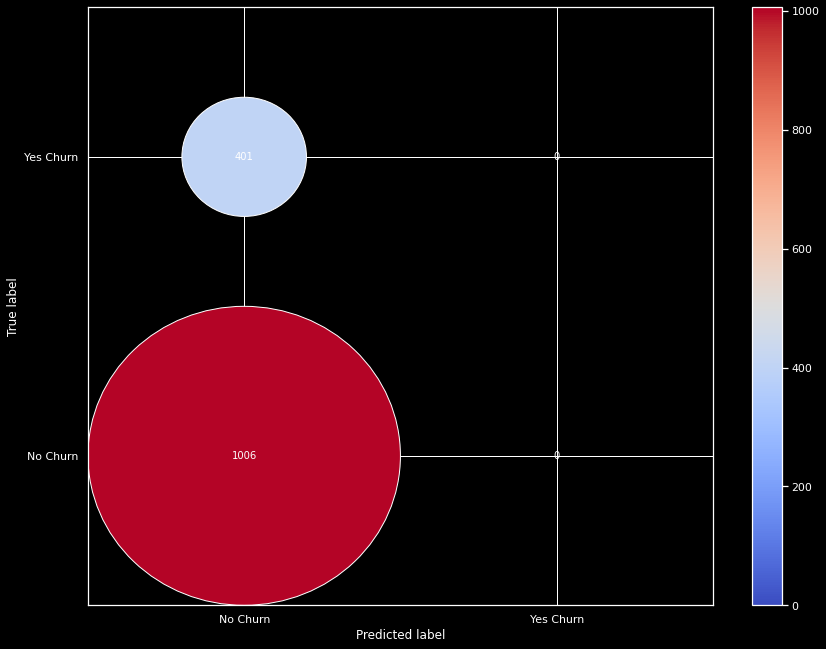

In [ ]:
#Predictions on the holdout
dtP = dtGs.predict(X_test)
plot_cm(confusion_matrix(y_test, dtP),['No Churn','Yes Churn'],False)

In [ ]:
print(classification_report(y_test, dtP, target_names=target_names))

              precision    recall  f1-score   support

    No Churn       0.71      1.00      0.83      1006
   Yes Churn       0.00      0.00      0.00       401

    accuracy                           0.71      1407
   macro avg       0.36      0.50      0.42      1407
weighted avg       0.51      0.71      0.60      1407



## K Nearest Neighbors

In [ ]:
#K nearest neighbors
knn = KNeighborsClassifier()

#parameters
knnPara = {'n_neighbors': [3, 9, 39, 12],
           'weights': ['uniform', 'distance'],
           'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 
           'leaf_size': [30, 12, 9, 3, 17],  
           'metric': ['mahalanobis','euclidean', 'manhattan', 'chebyshev', 'minkowski', 'seuclidean']   
          }

knnGs = GridSearchCV(knn, knnPara, cv=cv)

knnGs.fit(X_train, y_train)

print("Parameters: {} \n Score: {:.2f}".format(knnGs.best_params_, knnGs.best_score_))
dummyCompetition(knnGs.best_score_)

Parameters: {'algorithm': 'brute', 'leaf_size': 30, 'metric': 'mahalanobis', 'n_neighbors': 39, 'weights': 'uniform'} 
 Score: 0.74


'You Won!'

In [ ]:
#Update the results table
results = results.append(getBest('knn', knnGs.cv_results_, knnGs.best_index_))
#look at the results
results[results['model'] == 'knn'].dropna(axis=1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,mean_test_score,std_test_score,rank_test_score,model,param_algorithm,param_leaf_size,param_metric,param_n_neighbors,param_weights
25,0.005280,0.000069,0.004813,0.000085,0.684267,0.004882,691,knn,auto,30,chebyshev,3,distance
901,0.002282,0.000027,0.131587,0.002450,0.718578,0.004656,279,knn,brute,3,minkowski,39,distance
724,0.002366,0.000029,0.308445,0.003590,0.738844,0.006825,1,knn,brute,30,mahalanobis,39,uniform


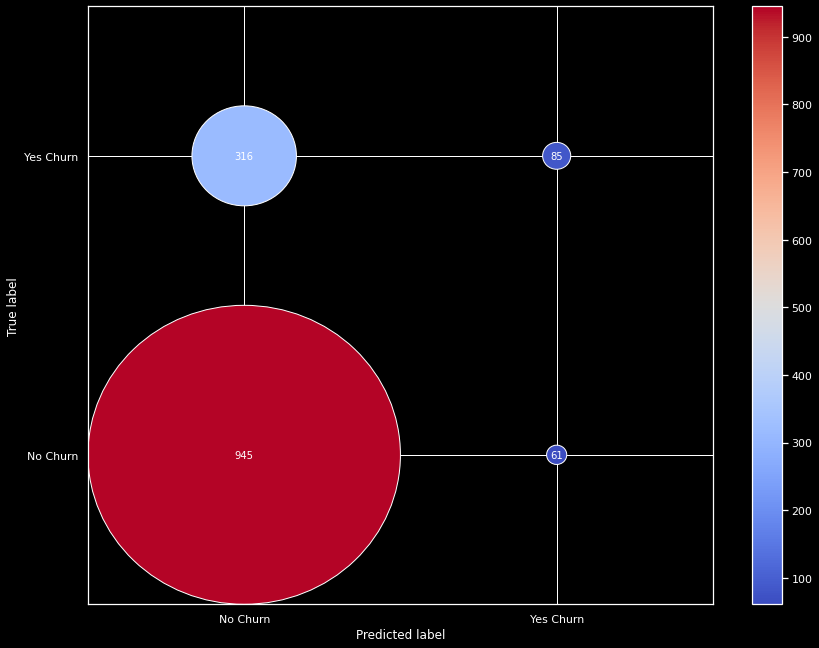

In [ ]:
#Predictions on the holdout
knnP = knnGs.predict(X_test)
plot_cm(confusion_matrix(y_test, knnP),['No Churn','Yes Churn'],False)

In [ ]:
print(classification_report(y_test, knnP, target_names=target_names))

              precision    recall  f1-score   support

    No Churn       0.75      0.94      0.83      1006
   Yes Churn       0.58      0.21      0.31       401

    accuracy                           0.73      1407
   macro avg       0.67      0.58      0.57      1407
weighted avg       0.70      0.73      0.68      1407



## Support Vector Classifier


In [ ]:
#support vector machine
svc = SVC()

#parameters
svcPara = {
          'kernel': ['linear', 'rbf'],
          'break_ties': [True, False] 
          }

svcGs = GridSearchCV(svc, svcPara, cv=cv)

svcGs.fit(X_train, y_train)

print("Parameters: {} \n Score: {:.2f}".format(svcGs.best_params_, svcGs.best_score_))
dummyCompetition(svcGs.best_score_)

Parameters: {'break_ties': True, 'kernel': 'linear'} 
 Score: 0.74


'You Won!'

In [ ]:
#Update the results table
results = results.append(getBest('svc', svcGs.cv_results_, svcGs.best_index_))
#look at the results
results[results['model'] == 'svc'].dropna(axis=1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,mean_test_score,std_test_score,rank_test_score,model,param_break_ties,param_kernel
2,71.247735,5.434761,0.025924,0.000464,0.739022,0.000435,1,svc,False,linear
3,0.409441,0.009363,0.076695,0.000971,0.739022,0.000435,1,svc,False,rbf
0,71.104027,5.353479,0.026321,0.001492,0.739022,0.000435,1,svc,True,linear


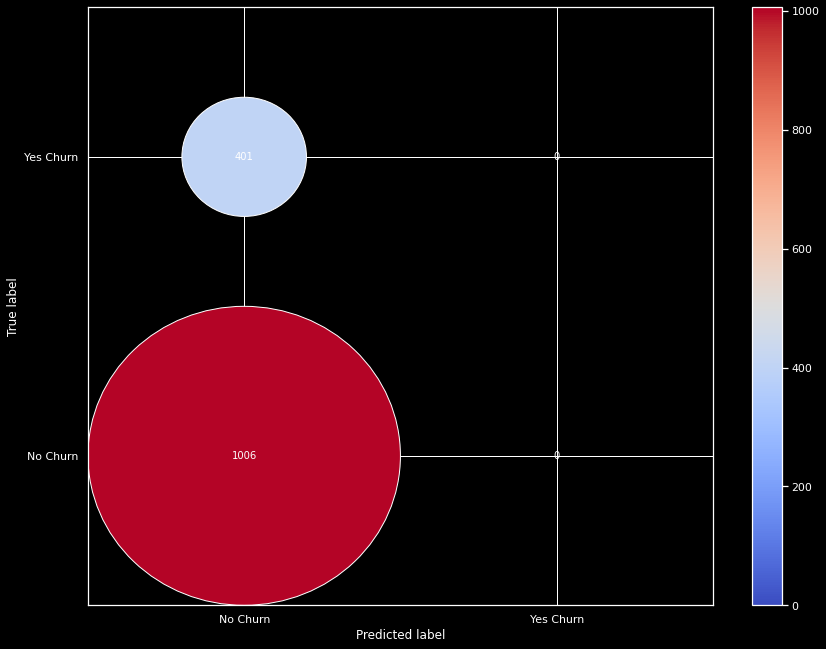

In [ ]:
#Predictions on the holdout
svcP = svcGs.predict(X_test)
plot_cm(confusion_matrix(y_test, svcP),['No Churn','Yes Churn'],False)

In [ ]:
print(classification_report(y_test, svcP, target_names=target_names))

              precision    recall  f1-score   support

    No Churn       0.71      1.00      0.83      1006
   Yes Churn       0.00      0.00      0.00       401

    accuracy                           0.71      1407
   macro avg       0.36      0.50      0.42      1407
weighted avg       0.51      0.71      0.60      1407



## Random Forest Classifier 

In [ ]:
#Random Forest Classifier
rfc = RandomForestClassifier()


#parameters 
rfcPara = {'criterion': cn,
           'max_features': mf,
           'oob_score':[True, False], 
           'max_depth': md     
          }

rfcGs = GridSearchCV(rfc, rfcPara, cv=cv)

rfcGs.fit(X_train, y_train)

print("Parameters: {} \n Score: {:.2f}".format(rfcGs.best_params_, rfcGs.best_score_))
dummyCompetition(rfcGs.best_score_)

Parameters: {'criterion': 'entropy', 'max_depth': 5, 'max_features': 'auto', 'oob_score': False} 
 Score: 0.74


'You Won!'

In [ ]:
#Update the results table
results = results.append(getBest('rfc', rfcGs.cv_results_, rfcGs.best_index_))
#look at the results
results[results['model'] == 'rfc'].dropna(axis=1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,mean_test_score,std_test_score,rank_test_score,model,param_criterion,param_max_depth,param_max_features,param_oob_score
3,0.261928,0.003985,0.017593,0.000242,0.736889,0.004015,20,rfc,gini,5,sqrt,False
24,0.383172,0.005111,0.017512,0.000224,0.738489,0.000871,5,rfc,entropy,5,auto,True
25,0.314788,0.006788,0.017939,0.000638,0.739022,0.000435,1,rfc,entropy,5,auto,False


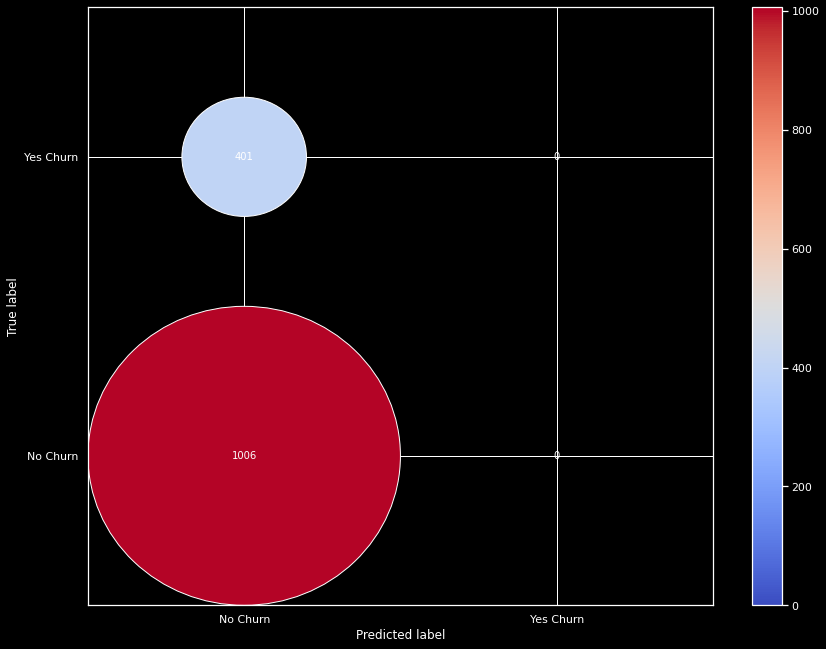

In [ ]:
#Predictions on the holdout
rfcP = rfcGs.predict(X_test)
plot_cm(confusion_matrix(y_test, rfcP),['No Churn','Yes Churn'],False)

In [ ]:
print(classification_report(y_test, rfcP, target_names=target_names))

              precision    recall  f1-score   support

    No Churn       0.71      1.00      0.83      1006
   Yes Churn       0.00      0.00      0.00       401

    accuracy                           0.71      1407
   macro avg       0.36      0.50      0.42      1407
weighted avg       0.51      0.71      0.60      1407



## Gradient Boosting Classifier


In [ ]:
#Gradient Boosting Classifier
gbc = GradientBoostingClassifier()

#parameters 
gbcPara = {'criterion': ['friedman_mse', 'mse', 'mae'],
           'max_features': mf,
           'max_depth': md     
          }

gbcGs = GridSearchCV(gbc, gbcPara, cv=cv)

gbcGs.fit(X_train, y_train)

print("Parameters: {} \n Score: {:.2f}".format(gbcGs.best_params_, gbcGs.best_score_))
dummyCompetition(gbcGs.best_score_)

Parameters: {'criterion': 'mae', 'max_depth': 5, 'max_features': 'log2'} 
 Score: 0.74


'You Won!'

In [ ]:
#Update the results table
results = results.append(getBest('gbc', gbcGs.cv_results_, gbcGs.best_index_))
#look at the results
results[results['model'] == 'gbc'].dropna(axis=1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,mean_test_score,std_test_score,rank_test_score,model,param_criterion,param_max_depth,param_max_features
1,0.347862,0.003782,0.005822,0.000118,0.733156,0.009210,6,gbc,friedman_mse,5,sqrt
24,27.733295,1.192775,0.004386,0.000224,0.734222,0.003079,4,gbc,mae,5,auto
26,14.961702,0.319432,0.006152,0.000076,0.737422,0.009876,1,gbc,mae,5,log2


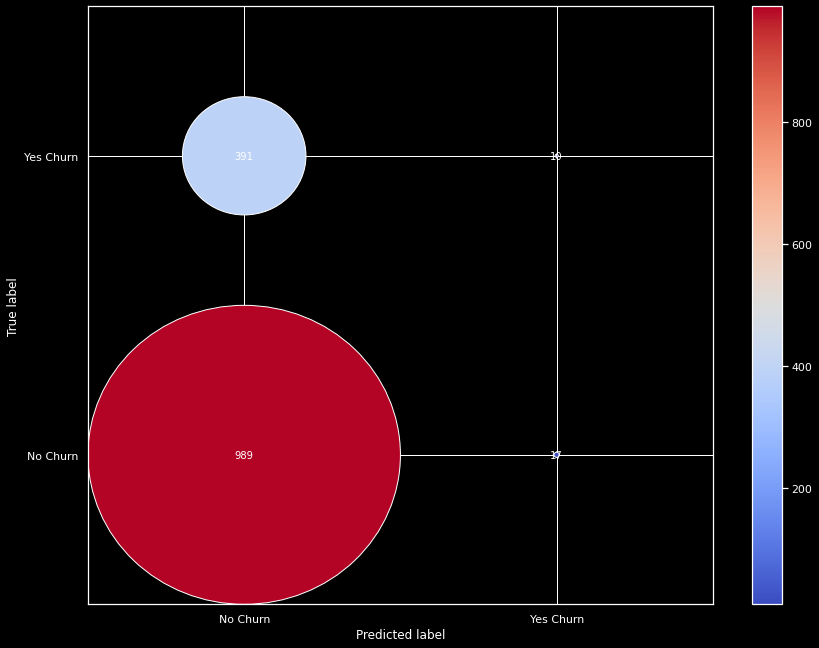

In [ ]:
#Predictions on the holdout
gbcP = gbcGs.predict(X_test)
plot_cm(confusion_matrix(y_test, gbcP),['No Churn','Yes Churn'],False)

In [ ]:
print(classification_report(y_test, gbcP, target_names=target_names))

              precision    recall  f1-score   support

    No Churn       0.72      0.98      0.83      1006
   Yes Churn       0.37      0.02      0.05       401

    accuracy                           0.71      1407
   macro avg       0.54      0.50      0.44      1407
weighted avg       0.62      0.71      0.61      1407



# Time Analyis/Comparison


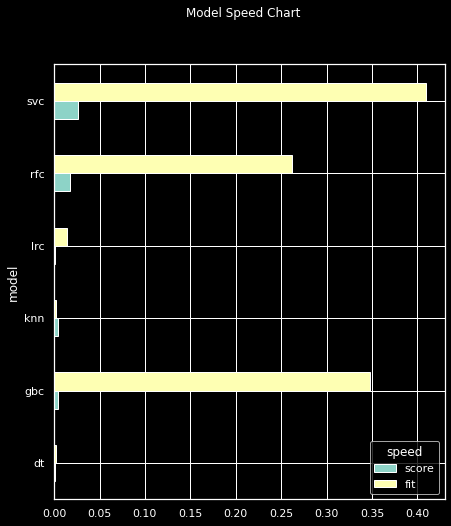

In [ ]:
#A bar graph representing the process times. 
plt.style.use(['dark_background'])
timecol = ['model', 'mean_score_time', 'mean_fit_time'] 
results[timecol].groupby(by='model').min().plot.barh(figsize=(7,8))
plt.suptitle('Model Speed Chart', color='w')
plt.legend(['score', 'fit'], loc='lower right', title='speed')
plt.show()

# Conclusion

The dummy classifier was the best model to use for this project. 

It did a superb job in providing a baseline for the accuracy, precision, and recall on all models. Using this classifier as a baseline for feature engineering success will lead to optimized model selection and evaluation. 

In [ ]:
dumResults[['mean_fit_time', 'mean_score_time']].mean()

mean_fit_time      0.001263
mean_score_time    0.000475
dtype: float64

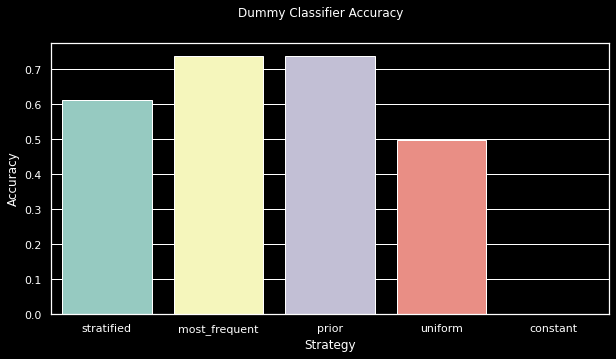

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
#call the bar plot.
sns.barplot(data=dumResults[['mean_test_score', 'param_strategy']], x='param_strategy', y='mean_test_score', ax=ax)
#set the x and y labels.
ax.set(ylabel='Accuracy', xlabel='Strategy')
#name the plot.
plt.suptitle("Dummy Classifier Accuracy")
plt.show()

# *afterward*

With 73% accuracy and high precision and recall scores on predicting that individuals will not turn over, I recommend that action be taken to reduce churn.

I suggest that the company introduce bundled services that will reduce  customers' monthly charges. 

Another analysis would need to be conducted in order to determine which services should be bundled and how many. It is possible that one of these prediction models can aide in determining these factors. 